# Neurogenesis Demo
Train an autoencoder on a small MNIST subset and generate intrinsic replay samples.

In [12]:
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.loggers import MLFlowLogger

from data.mnist_datamodule import MNISTDataModule
from models.autoencoder import AutoEncoder
from training.intrinsic_replay_runner import run_intrinsic_replay

In [13]:
# datamodule restricted to digits 0 and 1
dm = MNISTDataModule(batch_size=64, num_workers=0, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
dm.setup()

In [14]:
# LightningModule wrapping the AutoEncoder
class LitWrapper(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.ae = model
        self.loss_fn = torch.nn.MSELoss()
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        return self.ae(x)

    def training_step(self, batch, batch_idx):
        imgs, _ = batch
        out = self(imgs)
        loss = self.loss_fn(out["recon"], imgs.view(imgs.size(0), -1))
        self.train_losses.append(loss.item())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        out = self(imgs)
        self._last_imgs = imgs
        self._last_recons = out["recon"].view_as(imgs)
        loss = self.loss_fn(out["recon"], imgs.view(imgs.size(0), -1))
        self.val_losses.append(loss.item())
        self.log("val_loss", loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def on_validation_epoch_end(self):
        grid = torchvision.utils.make_grid(
            torch.cat([self._last_imgs, self._last_recons], dim=0),
            nrow=self._last_imgs.size(0),
        )
        self.example_grid = grid
        self._last_imgs = None
        self._last_recons = None

In [15]:
model = AutoEncoder(input_dim=28 * 28, hidden_sizes=[64, 32], activation="relu")
lit = LitWrapper(model)
logger = MLFlowLogger(experiment_name="demo")
trainer = pl.Trainer(max_epochs=20, logger=logger)
trainer.fit(lit, dm)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | ae      | AutoEncoder | 105 K  | train
1 | loss_fn | MSELoss     | 0      | train
------------------------------------------------
105 K     Trainable params
0         Non-trainable params
105 K     Total params
0.422     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 938/938 [00:31<00:00, 29.83it/s, v_num=df42]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 938/938 [00:31<00:00, 29.77it/s, v_num=df42]


Train losses: [0.23144537210464478, 0.23076346516609192, 0.23049752414226532, 0.22894598543643951, 0.22846198081970215, 0.2259950041770935, 0.22442996501922607, 0.22031518816947937, 0.21829114854335785, 0.21351560950279236, 0.2082740068435669, 0.20329691469669342, 0.19686204195022583, 0.189620241522789, 0.18358319997787476, 0.17647044360637665, 0.1650322824716568, 0.16000613570213318, 0.15073935687541962, 0.14074155688285828, 0.130943164229393, 0.12212126702070236, 0.11387285590171814, 0.10722021758556366, 0.10378111153841019, 0.09760043025016785, 0.09176235646009445, 0.08764458447694778, 0.08822546899318695, 0.08291657269001007, 0.08025651425123215, 0.08186842501163483, 0.07409393042325974, 0.08051417768001556, 0.08128172159194946, 0.0778055340051651, 0.07409866154193878, 0.07306624948978424, 0.07694383710622787, 0.0746578797698021, 0.07102486491203308, 0.07289925962686539, 0.07963986694812775, 0.06880020350217819, 0.07122557610273361, 0.07277963310480118, 0.07063768804073334, 0.07470

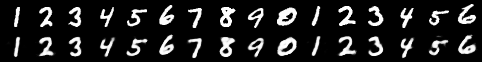

In [16]:
print("Train losses:", lit.train_losses)
print("Val losses:", lit.val_losses)
display(torchvision.transforms.ToPILImage()(lit.example_grid))

In [17]:
run_intrinsic_replay(
    encoder=model.encoder,
    decoder=model.decoder,
    dataloader=dm.train_dataloader(),
    mlf_logger=logger,
    n_samples_per_class=16,
    device=trainer.strategy.root_device,
)

✅ intrinsic-replay artifacts logged under run 42039ae94fe54e979629a8163c20df42


In [18]:
# display the intrinsic replay images logged for class 0 and 1
from pathlib import Path
import matplotlib.pyplot as plt

artifacts = Path(logger.experiment.get_run(logger.run_id).info.artifact_uri)
for cls in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    img = plt.imread(artifacts / f"ir_replay/class_{cls}/ir_class_{cls}.png")
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"IR samples for class {cls}")

OSError: [Errno 22] Invalid argument: 'file:c:\\Users\\Admin\\Documents\\GitHub\\Neurogenesis\\notebooks\\mlruns\\161635228958559076\\42039ae94fe54e979629a8163c20df42\\artifacts\\ir_replay\\class_0\\ir_class_0.png'